<a href="https://colab.research.google.com/github/chcorophyll/hands-on-mamchine-learning-with-sklearn-and-tensorlow/blob/master/my_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "deep"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

**Vanishing/Exploding Gradients Problem**

In [0]:
def logit(z):
    return 1 / (1 + np.exp(-z))

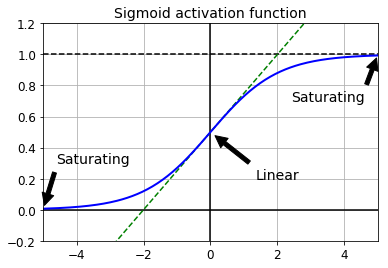

In [0]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

**Xavier and He Initialization**

In [0]:
import tensorflow as tf

In [0]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [5]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, 
                         activation=tf.nn.relu, 
                         kernel_initializer=he_init,
                         name="hidden1")


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


**Nonsaturating Activation Functions**

**Leaky ReLU**

In [0]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

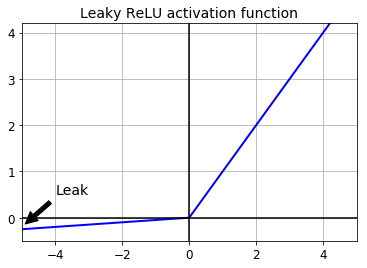

In [0]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

**Implementing Leaky ReLU in TensorFlow:**

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [0]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
# load data

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [18]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.904
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9652
15 Batch accuracy: 0.94 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.976
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


**ELU**

In [0]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

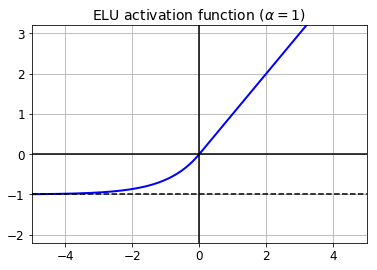

In [0]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()


Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, 
                          activation=tf.nn.elu,
                          name="hidden1")

**SELU**

This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [0]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

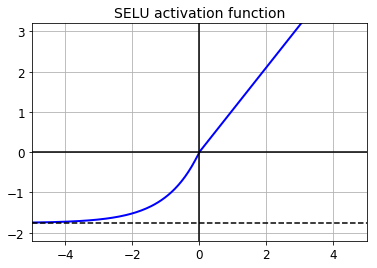

In [0]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("selu_plot")
plt.show()

In [23]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [0]:
# The tf.nn.selu() function was added in TensorFlow 1.4. 
# For earlier versions, you can use the following implementation:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

Let's create a neural net for MNIST using the SELU activation function:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [26]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.94 Validation accuracy: 0.9388
5 Batch accuracy: 0.98 Validation accuracy: 0.9634
10 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 1.0 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9696
30 Batch accuracy: 1.0 Validation accuracy: 0.9706
35 Batch accuracy: 1.0 Validation accuracy: 0.9704


In [27]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.batch_normalization instead.


In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's partial() function:

In [0]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [30]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [31]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


In [0]:
# # Note that you could also make the training operation depend on the update operations:
# with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     with tf.control_dependencies(extra_update_ops):
#         training_op = optimizer.minimize(loss)
# # This way, you would just have to evaluate the training_op during training, TensorFlow would automatically run the update operations as well:
# sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [32]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [33]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

**Gradient Clipping**

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

In [0]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) 
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 200

In [0]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2878
1 Validation accuracy: 0.7938
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.9064
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.922
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9418
10 Validation accuracy: 0.946
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.9564
16 Validation accuracy: 0.958
17 Validation accuracy: 0.9594
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9614


**Reusing Pretrained Layers**

**Reusing a TensorFlow Model**

In [0]:
reset_graph()

In [0]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [0]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [0]:
!pip install -q tf-nightly-2.0-preview

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 6, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 40, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 39, in <module>
    from tensorboard.plugins.beholder import beholder_plugin_loader
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/plugins/beholder/__init__.py", line 18, in <module>
    import tensorflow
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py", line 93, in <module>
    from tensorflow_core import *
AttributeError: module 'tensorflow_core' has no attribute 'compiler'

In [0]:
from google.colab import files
import zipfile, io, os

def upload_dir_file(case_f):
    # author: yasser mustafa, 21 March 2018  
    # case_f = 0 for uploading one File or Package(.py) and case_f = 1 for uploading one Zipped Directory
    uploaded = files.upload()    # to upload a Full Directory, please Zip it first (use WinZip)
    for fn in uploaded.keys():
        name = fn  #.encode('utf-8')
        #print('\nfile after encode', name)
        #name = io.BytesIO(uploaded[name])
    if case_f == 0:    # case of uploading 'One File only'
        print('\n file name: ', name)
        return name
    else:   # case of uploading a directory and its subdirectories and files
        zfile = zipfile.ZipFile(name, 'r')   # unzip the directory 
        zfile.extractall()
        for d in zfile.namelist():   # d = directory
            print('\n main directory name: ', d)
            return d
print('Done!')

Done!


In [0]:
tensorflow_graph_in_jupyter = upload_dir_file(0)

Saving tensorflow_graph_in_jupyter.py to tensorflow_graph_in_jupyter (1).py

 file name:  tensorflow_graph_in_jupyter.py


In [0]:
from tensorflow_graph_in_jupyter import show_graph

show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

In [0]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [0]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [0]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [0]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [0]:
# Actually, let's test this for real!
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9634
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.965
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9688
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9718
12 Validation accuracy: 0.9676
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.971
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9724
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.971


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of import_meta_graph():

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [0]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9654
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.972
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


In general you will want to reuse only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [0]:
reset_graph()

n_hidden4 = 20
n_outputs = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [0]:
# train this new model


with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9186
1 Validation accuracy: 0.9394
2 Validation accuracy: 0.9486
3 Validation accuracy: 0.9526
4 Validation accuracy: 0.9554
5 Validation accuracy: 0.956
6 Validation accuracy: 0.9576
7 Validation accuracy: 0.961
8 Validation accuracy: 0.9612
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.965
11 Validation accuracy: 0.966
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9672
14 Validation accuracy: 0.969
15 Validation accuracy: 0.9684
16 Validation accuracy: 0.9702
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9694
19 Validation accuracy: 0.97


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")# regular expression
restore_saver = tf.train.Saver(reuse_vars)# to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9024
1 Validation accuracy: 0.9336
2 Validation accuracy: 0.9428
3 Validation accuracy: 0.947
4 Validation accuracy: 0.952
5 Validation accuracy: 0.9534
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.9588
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9604
10 Validation accuracy: 0.9622
11 Validation accuracy: 0.962
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.966
14 Validation accuracy: 0.9662
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.968
19 Validation accuracy: 0.9676


**Reusing Models from Other Frameworks**

In [0]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [0]:

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [0]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using get_collection() and specifying the scope:

In [0]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's get_tensor_by_name() method:

In [0]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [0]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

**Freezing the Lower Layers**

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9406
3 Validation accuracy: 0.9444
4 Validation accuracy: 0.948
5 Validation accuracy: 0.9508
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9534
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.9564
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.9576
14 Validation accuracy: 0.9586
15 Validation accuracy: 0.958
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.96
18 Validation accuracy: 0.959
19 Validation accuracy: 0.96


In [0]:

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2) ######## change
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9026
1 Validation accuracy: 0.9308
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9512
5 Validation accuracy: 0.9528
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.956
10 Validation accuracy: 0.957
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.958
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


**Caching the Frozen Layers**

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown
    
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9026
1 Validation accuracy: 0.9308
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9512
5 Validation accuracy: 0.9528
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.956
10 Validation accuracy: 0.957
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.958
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


**Faster Optimizers**

In [0]:
# Momentum optimization
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

# Nesterov Accelerated Gradient
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

# AdaGrad
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

# RMSProp
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

# Adam Optimization
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

**Learning Rate Scheduling**

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9662
1 Validation accuracy: 0.9736
2 Validation accuracy: 0.9704
3 Validation accuracy: 0.9822
4 Validation accuracy: 0.9836


**Avoiding Overfitting Through Regularization**

**$\ell_1$ and $\ell_2$ regularization**

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [0]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [0]:
# reset_graph()

# n_inputs = 28 * 28  # MNIST
# n_hidden1 = 300
# n_hidden2 = 50
# n_outputs = 10

# X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
# scale = 0.001

In [0]:
# use Python's partial() function to avoid repeating the same arguments over and over again. 
# Note that we set the kernel_regularizer argument:

# my_dense_layer = partial(
#     tf.layers.dense, activation=tf.nn.relu,
#     kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

# with tf.name_scope("dnn"):
#     hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
#     hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
#     logits = my_dense_layer(hidden2, n_outputs, activation=None,
#                             name="outputs")

In [0]:
# with tf.name_scope("loss"):                                     # not shown in the book
#     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
#         labels=y, logits=logits)                                # not shown
#     base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
#     reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [0]:

# with tf.name_scope("eval"):
#     correct = tf.nn.in_top_k(logits, y, 1)
#     accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

# learning_rate = 0.01

# with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     training_op = optimizer.minimize(loss)

# init = tf.global_variables_initializer()
# saver = tf.train.Saver()

In [0]:
# n_epochs = 20
# batch_size = 200

# with tf.Session() as sess:
#     init.run()
#     for epoch in range(n_epochs):
#         for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
#             sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#         accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
#         print(epoch, "Validation accuracy:", accuracy_val)

#     save_path = saver.save(sess, "./my_model_final.ckpt")

**Dropout**

In [0]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
training = tf.placeholder_with_default(False, shape=(), name="training")

dropout_rate = 0.5 # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, 
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9264
1 Validation accuracy: 0.9464
2 Validation accuracy: 0.9518
3 Validation accuracy: 0.9554
4 Validation accuracy: 0.9596
5 Validation accuracy: 0.9632
6 Validation accuracy: 0.9616
7 Validation accuracy: 0.9662
8 Validation accuracy: 0.97
9 Validation accuracy: 0.968
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9722
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.9714
14 Validation accuracy: 0.9722
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9738
17 Validation accuracy: 0.9734
18 Validation accuracy: 0.9734
19 Validation accuracy: 0.975


**Max norm**

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
# Next, let's get a handle on the first hidden layer's weight and
# create an operation that will compute the clipped weights using 
# the clip_by_norm() function. Then we create an assignment operation 
# to assign the clipped weights to the weights variable:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [0]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 50

In [0]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt") 

0 Validation accuracy: 0.9574
1 Validation accuracy: 0.9702
2 Validation accuracy: 0.971
3 Validation accuracy: 0.9762
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9776
6 Validation accuracy: 0.982
7 Validation accuracy: 0.9822
8 Validation accuracy: 0.982
9 Validation accuracy: 0.9822
10 Validation accuracy: 0.9832
11 Validation accuracy: 0.9852
12 Validation accuracy: 0.9828
13 Validation accuracy: 0.9836
14 Validation accuracy: 0.984
15 Validation accuracy: 0.9844
16 Validation accuracy: 0.9848
17 Validation accuracy: 0.9846
18 Validation accuracy: 0.9852
19 Validation accuracy: 0.9846


A better approach is to define a max_norm_regularizer() function:

In [0]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
max_norm_reg = max_norm_regularizer(threshold=1.0)
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 20
batch_size = 50

In [0]:
clip_all_weights = tf.get_collection("max_norm")

In [0]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")    

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9702
2 Validation accuracy: 0.973
3 Validation accuracy: 0.975
4 Validation accuracy: 0.9766
5 Validation accuracy: 0.9782
6 Validation accuracy: 0.9802
7 Validation accuracy: 0.9814
8 Validation accuracy: 0.9814
9 Validation accuracy: 0.9808
10 Validation accuracy: 0.9826
11 Validation accuracy: 0.9816
12 Validation accuracy: 0.9804
13 Validation accuracy: 0.9814
14 Validation accuracy: 0.9826
15 Validation accuracy: 0.9818
16 Validation accuracy: 0.982
17 Validation accuracy: 0.9826
18 Validation accuracy: 0.9818
19 Validation accuracy: 0.983


**Exercise solutions**

**8. Deep Learning**

8.1.Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function.

In [0]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, 
        name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, 
                                     activation=activation,
                                     kernel_initializer=initializer, 
                                     name="hidden%d"%(layer+1))
        return inputs

In [0]:
n_inputs = 28 * 28
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, 
                         kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

8.2.
Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.

In [0]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [38]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.139974	Best loss: 0.139974	Accuracy: 96.79%
1	Validation loss: 1.717267	Best loss: 0.139974	Accuracy: 18.73%
2	Validation loss: 1.675321	Best loss: 0.139974	Accuracy: 20.91%
3	Validation loss: 1.781255	Best loss: 0.139974	Accuracy: 19.08%
4	Validation loss: 1.665935	Best loss: 0.139974	Accuracy: 22.01%
5	Validation loss: 1.653329	Best loss: 0.139974	Accuracy: 22.01%
6	Validation loss: 1.680773	Best loss: 0.139974	Accuracy: 18.73%
7	Validation loss: 1.778848	Best loss: 0.139974	Accuracy: 22.01%
8	Validation loss: 1.699488	Best loss: 0.139974	Accuracy: 19.27%
9	Validation loss: 1.767767	Best loss: 0.139974	Accuracy: 20.91%
10	Validation loss: 1.629342	Best loss: 0.139974	Accuracy: 22.01%
11	Validation loss: 1.812649	Best loss: 0.139974	Accuracy: 22.01%
12	Validation loss: 1.675937	Best loss: 0.139974	Accuracy: 18.73%
13	Validation loss: 1.633258	Best loss: 0.139974	Accuracy: 20.91%
14	Validation loss: 1.652907	Best loss: 0.139974	Accuracy: 20.91%
15	Validation loss: 

8.3.Tune the hyperparameters using cross-validation and see what precision you can achieve.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [42]:
# get the exact same accuracy as earlier using this class (without dropout or batch norm):
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.213366	Best loss: 0.213366	Accuracy: 95.04%
1	Validation loss: 0.197189	Best loss: 0.197189	Accuracy: 96.79%
2	Validation loss: 0.136886	Best loss: 0.136886	Accuracy: 96.33%
3	Validation loss: 1.734789	Best loss: 0.136886	Accuracy: 22.01%
4	Validation loss: 1.653337	Best loss: 0.136886	Accuracy: 22.01%
5	Validation loss: 1.639877	Best loss: 0.136886	Accuracy: 22.01%
6	Validation loss: 1.672531	Best loss: 0.136886	Accuracy: 18.73%
7	Validation loss: 1.767512	Best loss: 0.136886	Accuracy: 22.01%
8	Validation loss: 1.700038	Best loss: 0.136886	Accuracy: 19.27%
9	Validation loss: 1.766613	Best loss: 0.136886	Accuracy: 20.91%
10	Validation loss: 1.629351	Best loss: 0.136886	Accuracy: 22.01%
11	Validation loss: 1.812614	Best loss: 0.136886	Accuracy: 22.01%
12	Validation loss: 1.675935	Best loss: 0.136886	Accuracy: 18.73%
13	Validation loss: 1.633258	Best loss: 0.136886	Accuracy: 20.91%
14	Validation loss: 1.652907	Best loss: 0.136886	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f56f837e400>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f56b9ea57f0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [43]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9659466822338977

use Scikit-Learn's RandomizedSearchCV class to search for better hyperparameters (this may take over an hour, depending on your system）

In [44]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7f56f837e400> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.145862	Best loss: 0.145862	Accuracy: 96.29%
1	Validation loss: 0.132970	Best loss: 0.132970	Accuracy: 96.48%
2	Validation loss: 0.124297	Best loss: 0.124297	Accuracy: 96.83%
3	Validation loss: 0.109727	Best loss: 0.109727	Accuracy: 96.91%
4	Validation loss: 0.133041	Best loss: 0.109727	Accuracy: 97.22%
5	Validation loss: 0.121177	Best loss: 0.109727	Accuracy: 96.79%
6	Validation loss: 0.130760	Best loss: 0.109727	Accuracy: 97.46%
7	Validation loss: 0.164932	Best loss: 0.109727	Accuracy: 96.91%
8	Validation loss: 1.631054	Best loss: 0.109727	Accuracy: 19.27%
9	Validation loss: 1.625293	Best loss: 0.109727	Accuracy: 22.01%
10	Validation loss: 1.608989	Best loss: 0.109727	Accuracy: 22.01%
11	Validation loss: 1.613094	Best loss: 0.109727	Accuracy: 20.91%
12	Validation loss: 1.642190	Best loss: 0.109727	Accuracy: 20.91%
13	Validation loss: 1.634384	Best loss: 0.109727	Accuracy: 18.73%
14	Validation loss: 1.630509	Best loss: 0.109727	Accuracy: 22.01%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


0	Validation loss: 0.163825	Best loss: 0.163825	Accuracy: 95.86%
1	Validation loss: 0.149375	Best loss: 0.149375	Accuracy: 96.76%
2	Validation loss: 0.122544	Best loss: 0.122544	Accuracy: 96.64%
3	Validation loss: 0.136912	Best loss: 0.122544	Accuracy: 96.83%
4	Validation loss: 0.132052	Best loss: 0.122544	Accuracy: 97.03%
5	Validation loss: 0.125902	Best loss: 0.122544	Accuracy: 97.19%
6	Validation loss: 0.099720	Best loss: 0.099720	Accuracy: 97.65%
7	Validation loss: 0.117470	Best loss: 0.099720	Accuracy: 97.65%
8	Validation loss: 0.104201	Best loss: 0.099720	Accuracy: 97.42%
9	Validation loss: 1.562591	Best loss: 0.099720	Accuracy: 25.10%
10	Validation loss: 1.579273	Best loss: 0.099720	Accuracy: 23.85%
11	Validation loss: 1.607463	Best loss: 0.099720	Accuracy: 21.03%
12	Validation loss: 1.230536	Best loss: 0.099720	Accuracy: 37.92%
13	Validation loss: 1.280556	Best loss: 0.099720	Accuracy: 35.61%
14	Validation loss: 1.225731	Best loss: 0.099720	Accuracy: 40.66%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 60.6min finished


0	Validation loss: 0.083541	Best loss: 0.083541	Accuracy: 97.54%
1	Validation loss: 0.050669	Best loss: 0.050669	Accuracy: 98.44%
2	Validation loss: 0.043900	Best loss: 0.043900	Accuracy: 98.63%
3	Validation loss: 0.074942	Best loss: 0.043900	Accuracy: 97.73%
4	Validation loss: 0.043287	Best loss: 0.043287	Accuracy: 98.48%
5	Validation loss: 0.066179	Best loss: 0.043287	Accuracy: 98.24%
6	Validation loss: 0.034663	Best loss: 0.034663	Accuracy: 98.87%
7	Validation loss: 0.032633	Best loss: 0.032633	Accuracy: 99.06%
8	Validation loss: 0.048279	Best loss: 0.032633	Accuracy: 98.79%
9	Validation loss: 0.050565	Best loss: 0.032633	Accuracy: 98.87%
10	Validation loss: 0.060831	Best loss: 0.032633	Accuracy: 98.71%
11	Validation loss: 0.039090	Best loss: 0.032633	Accuracy: 99.30%
12	Validation loss: 0.074995	Best loss: 0.032633	Accuracy: 98.20%
13	Validation loss: 0.047932	Best loss: 0.032633	Accuracy: 98.71%
14	Validation loss: 0.059969	Best loss: 0.032633	Accuracy: 98.87%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x7f56f837e400>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f56b9ea57f0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.pyth...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f56f06f0840>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f56b0d5ae18>],
                                        'batch_size': [10, 50, 100, 500],
                   

In [45]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [46]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9908542517999611

In [0]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

**8.4**.try adding Batch Normalization and compare the learning curves: is it converging faster than before

In [0]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.083541	Best loss: 0.083541	Accuracy: 97.54%
1	Validation loss: 0.052486	Best loss: 0.052486	Accuracy: 98.40%
2	Validation loss: 0.045944	Best loss: 0.045944	Accuracy: 98.79%
3	Validation loss: 0.063068	Best loss: 0.045944	Accuracy: 98.20%
4	Validation loss: 0.046236	Best loss: 0.045944	Accuracy: 98.55%
5	Validation loss: 0.045954	Best loss: 0.045944	Accuracy: 98.67%
6	Validation loss: 0.043678	Best loss: 0.043678	Accuracy: 98.98%
7	Validation loss: 0.043798	Best loss: 0.043678	Accuracy: 98.79%
8	Validation loss: 0.038216	Best loss: 0.038216	Accuracy: 98.87%
9	Validation loss: 0.043402	Best loss: 0.038216	Accuracy: 99.14%
10	Validation loss: 0.086780	Best loss: 0.038216	Accuracy: 98.36%
11	Validation loss: 0.046074	Best loss: 0.038216	Accuracy: 99.06%
12	Validation loss: 0.046149	Best loss: 0.038216	Accuracy: 98.79%
13	Validation loss: 0.055451	Best loss: 0.038216	Accuracy: 98.87%
14	Validation loss: 0.064588	Best loss: 0.038216	Accuracy: 98.79%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f72ba3f56a8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f72f4187208>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [0]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9898812998637867

In [0]:
# actually a slower convergence than earlier
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.045000	Best loss: 0.045000	Accuracy: 98.71%
1	Validation loss: 0.038686	Best loss: 0.038686	Accuracy: 98.67%
2	Validation loss: 0.038544	Best loss: 0.038544	Accuracy: 98.83%
3	Validation loss: 0.034455	Best loss: 0.034455	Accuracy: 98.91%
4	Validation loss: 0.041755	Best loss: 0.034455	Accuracy: 98.79%
5	Validation loss: 0.034809	Best loss: 0.034455	Accuracy: 98.83%
6	Validation loss: 0.033273	Best loss: 0.033273	Accuracy: 99.06%
7	Validation loss: 0.035015	Best loss: 0.033273	Accuracy: 99.10%
8	Validation loss: 0.029825	Best loss: 0.029825	Accuracy: 99.14%
9	Validation loss: 0.047721	Best loss: 0.029825	Accuracy: 98.75%
10	Validation loss: 0.037382	Best loss: 0.029825	Accuracy: 99.10%
11	Validation loss: 0.029679	Best loss: 0.029679	Accuracy: 99.10%
12	Validation loss: 0.031174	Best loss: 0.029679	Accuracy: 99.14%
13	Validation loss: 0.031403	Best loss: 0.029679	Accuracy: 99.22%
14	Validation loss: 0.048455	Best loss: 0.029679	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f72ea872840>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f72f4187208>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [0]:
# batch normalization improved accuracy
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9941622883829538

In [0]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f72feaa97b8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.094506	Best loss: 0.094506	Accuracy: 97.81%
1	Validation loss: 0.077330	Best loss: 0.077330	Accuracy: 97.97%
2	Validation loss: 0.077098	Best loss: 0.077098	Accuracy: 97.81%
3	Validation loss: 0.048680	Best loss: 0.048680	Accuracy: 98.51%
4	Validation loss: 0.040784	Best loss: 0.040784	Accuracy: 98.75%
5	Validation loss: 0.037025	Best loss: 0.037025	Accuracy: 99.06%
6	Validation loss: 0.037524	Best loss: 0.037025	Accuracy: 98.79%
7	Validation loss: 0.047306	Best loss: 0.037025	Accuracy: 98.75%
8	Validation loss: 0.038192	Best loss: 0.037025	Accuracy: 98.91%
9	Validation loss: 0.046032	Best loss: 0.037025	Accuracy: 98.71%
10	Validation loss: 0.044690	Best loss: 0.037025	Accuracy: 99.06%
11	Validation loss: 0.062298	Best loss: 0.037025	Accuracy: 98.75%
12	Validation loss: 0.056739	Best loss: 0.037025	Accuracy: 98.67%
13	Validation loss: 0.036190	Best loss: 0.036190	Accuracy: 99.02%
14	Validation loss: 0.042337	Best loss: 0.036190	Accuracy: 98.87%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


0	Validation loss: 0.136978	Best loss: 0.136978	Accuracy: 96.68%
1	Validation loss: 0.047414	Best loss: 0.047414	Accuracy: 98.75%
2	Validation loss: 0.077878	Best loss: 0.047414	Accuracy: 97.89%
3	Validation loss: 0.059870	Best loss: 0.047414	Accuracy: 98.36%
4	Validation loss: 0.041256	Best loss: 0.041256	Accuracy: 98.79%
5	Validation loss: 0.051351	Best loss: 0.041256	Accuracy: 98.51%
6	Validation loss: 0.042856	Best loss: 0.041256	Accuracy: 98.79%
7	Validation loss: 0.049032	Best loss: 0.041256	Accuracy: 98.67%
8	Validation loss: 0.059620	Best loss: 0.041256	Accuracy: 98.63%
9	Validation loss: 0.049783	Best loss: 0.041256	Accuracy: 98.87%
10	Validation loss: 0.056926	Best loss: 0.041256	Accuracy: 98.71%
11	Validation loss: 0.051924	Best loss: 0.041256	Accuracy: 98.79%
12	Validation loss: 0.038498	Best loss: 0.038498	Accuracy: 98.91%
13	Validation loss: 0.042500	Best loss: 0.038498	Accuracy: 98.79%
14	Validation loss: 0.035514	Best loss: 0.035514	Accuracy: 98.91%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 335.7min finished


0	Validation loss: 0.076224	Best loss: 0.076224	Accuracy: 97.65%
1	Validation loss: 0.053300	Best loss: 0.053300	Accuracy: 98.24%
2	Validation loss: 0.049056	Best loss: 0.049056	Accuracy: 98.79%
3	Validation loss: 0.040982	Best loss: 0.040982	Accuracy: 98.94%
4	Validation loss: 0.036727	Best loss: 0.036727	Accuracy: 98.71%
5	Validation loss: 0.032691	Best loss: 0.032691	Accuracy: 98.91%
6	Validation loss: 0.032595	Best loss: 0.032595	Accuracy: 99.02%
7	Validation loss: 0.039636	Best loss: 0.032595	Accuracy: 98.75%
8	Validation loss: 0.040700	Best loss: 0.032595	Accuracy: 98.91%
9	Validation loss: 0.038815	Best loss: 0.032595	Accuracy: 98.98%
10	Validation loss: 0.053711	Best loss: 0.032595	Accuracy: 98.75%
11	Validation loss: 0.060274	Best loss: 0.032595	Accuracy: 98.98%
12	Validation loss: 0.031601	Best loss: 0.031601	Accuracy: 99.06%
13	Validation loss: 0.045022	Best loss: 0.031601	Accuracy: 99.06%
14	Validation loss: 0.040874	Best loss: 0.031601	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x7f72feaa5268>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f72f4187208>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.pyth...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f72ba3f5158>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f72ba3f5e18>],
                                        'batch_norm_momentum': [0.9, 0.95, 0.98,
            

In [0]:
rnd_search_bn.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_norm_momentum': 0.98,
 'batch_size': 100,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [0]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9949406499318934

**8.5.**Try adding dropout to every layer and try again.

In [0]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9975747200228262

In [0]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.127027	Best loss: 0.127027	Accuracy: 96.79%
1	Validation loss: 0.091141	Best loss: 0.091141	Accuracy: 97.46%
2	Validation loss: 0.090984	Best loss: 0.090984	Accuracy: 97.26%
3	Validation loss: 0.090778	Best loss: 0.090778	Accuracy: 97.69%
4	Validation loss: 0.088474	Best loss: 0.088474	Accuracy: 97.42%
5	Validation loss: 0.078408	Best loss: 0.078408	Accuracy: 98.01%
6	Validation loss: 0.077858	Best loss: 0.077858	Accuracy: 98.12%
7	Validation loss: 0.080076	Best loss: 0.077858	Accuracy: 98.05%
8	Validation loss: 0.081029	Best loss: 0.077858	Accuracy: 98.01%
9	Validation loss: 0.074504	Best loss: 0.074504	Accuracy: 98.16%
10	Validation loss: 0.079312	Best loss: 0.074504	Accuracy: 97.93%
11	Validation loss: 0.078151	Best loss: 0.074504	Accuracy: 98.12%
12	Validation loss: 0.070155	Best loss: 0.070155	Accuracy: 98.28%
13	Validation loss: 0.079952	Best loss: 0.070155	Accuracy: 98.28%
14	Validation loss: 0.069348	Best loss: 0.069348	Accuracy: 98.48%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7279d656a8>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f72f4187208>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [0]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.985016540182915

In [0]:
# from sklearn.model_selection import RandomizedSearchCV

# param_distribs = {
#     "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
#     "batch_size": [10, 50, 100, 500],
#     "learning_rate": [0.01, 0.02, 0.05, 0.1],
#     "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
#     # you could also try exploring different numbers of hidden layers, different optimizers, etc.
#     #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
#     "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
# }

# rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                         cv=3, random_state=42, verbose=2)
# rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# # If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# # fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# # rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
# #                                         fit_params=fit_params, random_state=42, verbose=2)
# # rnd_search_dropout.fit(X_train1, y_train1)

**9. Transfer learning**

9.1.create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one.

In [0]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [0]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [0]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

9.2.train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes

create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to n_classes-1.

In [0]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [0]:
# small samples
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [0]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [54]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.137020	Best loss: 1.137020	Accuracy: 62.00%
1	Validation loss: 1.249135	Best loss: 1.137020	Accuracy: 60.00%
2	Validation loss: 0.955344	Best loss: 0.955344	Accuracy: 66.00%
3	Validation loss: 0.911255	Best loss: 0.911255	Accuracy: 61.33%
4	Validation loss: 0.999229	Best loss: 0.911255	Accuracy: 62.00%
5	Validation loss: 1.042283	Best loss: 0.911255	Accuracy: 59.33%
6	Validation loss: 0.921007	Best loss: 0.911255	Accuracy: 64.00%
7	Validation loss: 0.946872	Best loss: 0.911255	Accuracy: 62.00%
8	Validation loss: 1.044335	Best loss: 0.911255	Accuracy: 60.67%
9	Validation loss: 0.939974	Best loss: 0.911255	Accuracy: 60.67%
10	Validation loss: 0.954053	Best loss: 0.911255	Accuracy: 64.67%
11	Validation loss: 1.029816	Best loss: 0.911255	Accuracy: 60.00%
12	Validation loss: 0.907404	Best loss: 0.907404	Accuracy: 67.33%
13	Validation loss: 1.032571	Best loss: 0.907404	Accuracy: 58.67%
14	Validation l

9.3.caching the frozen layers, and train the model 

In [0]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [56]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.044662	Best loss: 1.044662	Accuracy: 60.00%
1	Validation loss: 1.013685	Best loss: 1.013685	Accuracy: 66.67%
2	Validation loss: 0.975045	Best loss: 0.975045	Accuracy: 63.33%
3	Validation loss: 0.914815	Best loss: 0.914815	Accuracy: 67.33%
4	Validation loss: 0.921637	Best loss: 0.914815	Accuracy: 67.33%
5	Validation loss: 0.973122	Best loss: 0.914815	Accuracy: 64.00%
6	Validation loss: 0.929856	Best loss: 0.914815	Accuracy: 67.33%
7	Validation loss: 0.928280	Best loss: 0.914815	Accuracy: 64.00%
8	Validation loss: 0.986569	Best loss: 0.914815	Accuracy: 63.33%
9	Validation loss: 1.233069	Best loss: 0.914815	Accuracy: 59.33%
10	Validation loss: 0.929395	Best loss: 0.914815	Accuracy: 66.00%
11	Validation loss: 0.903069	Best loss: 0.903069	Accuracy: 62.67%
12	Validation loss: 1.000956	Best loss: 0.903069	Accuracy: 65.33%
13	Validation loss: 0.847510	Best loss: 0.847510	Accuracy: 69.33%
14	Validation l

9.4.reusing just four hidden layers instead of five

In [0]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [59]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.987401	Best loss: 0.987401	Accuracy: 64.67%
1	Validation loss: 1.077178	Best loss: 0.987401	Accuracy: 65.33%
2	Validation loss: 0.825578	Best loss: 0.825578	Accuracy: 70.00%
3	Validation loss: 0.775615	Best loss: 0.775615	Accuracy: 72.67%
4	Validation loss: 0.840592	Best loss: 0.775615	Accuracy: 72.67%
5	Validation loss: 0.811614	Best loss: 0.775615	Accuracy: 65.33%
6	Validation loss: 0.791733	Best loss: 0.775615	Accuracy: 74.00%
7	Validation loss: 0.773194	Best loss: 0.773194	Accuracy: 71.33%
8	Validation loss: 0.906482	Best loss: 0.773194	Accuracy: 68.00%
9	Validation loss: 0.718133	Best loss: 0.718133	Accuracy: 73.33%
10	Validation loss: 0.745270	Best loss: 0.718133	Accuracy: 74.00%
11	Validation loss: 0.826663	Best loss: 0.718133	Accuracy: 68.67%
12	Validation loss: 0.741531	Best loss: 0.718133	Accuracy: 68.67%
13	Validation loss: 0.758077	Best loss: 0.718133	Accuracy: 72.00%
14	Validation l

9.5.unfreeze the top two hidden layers and continue training

In [0]:
earning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [61]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.724299	Best loss: 0.724299	Accuracy: 80.67%
1	Validation loss: 0.630952	Best loss: 0.630952	Accuracy: 84.00%
2	Validation loss: 0.779286	Best loss: 0.630952	Accuracy: 84.00%
3	Validation loss: 0.553774	Best loss: 0.553774	Accuracy: 87.33%
4	Validation loss: 0.674976	Best loss: 0.553774	Accuracy: 84.67%
5	Validation loss: 0.765031	Best loss: 0.553774	Accuracy: 84.67%
6	Validation loss: 0.641181	Best loss: 0.553774	Accuracy: 86.00%
7	Validation loss: 0.546258	Best loss: 0.546258	Accuracy: 88.00%
8	Validation loss: 0.770505	Best loss: 0.546258	Accuracy: 85.33%
9	Validation loss: 0.617494	Best loss: 0.546258	Accuracy: 88.67%
10	Validation loss: 0.544524	Best loss: 0.544524	Accuracy: 90.00%
11	Validation loss: 0.650566	Best loss: 0.544524	Accuracy: 88.67%
12	Validation loss: 0.781377	Best loss: 0.544524	Accuracy: 88.00%
13	Validation loss: 0.892029	Best loss: 0.544524	Accuracy: 83.33%
14	Valid

check what accuracy we can get by unfreezing all layers

In [0]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [63]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.673809	Best loss: 0.673809	Accuracy: 86.00%
1	Validation loss: 1.142692	Best loss: 0.673809	Accuracy: 79.33%
2	Validation loss: 1.352297	Best loss: 0.673809	Accuracy: 88.67%
3	Validation loss: 0.692945	Best loss: 0.673809	Accuracy: 90.67%
4	Validation loss: 0.647802	Best loss: 0.647802	Accuracy: 89.33%
5	Validation loss: 0.734836	Best loss: 0.647802	Accuracy: 90.00%
6	Validation loss: 0.595187	Best loss: 0.595187	Accuracy: 92.00%
7	Validation loss: 0.492726	Best loss: 0.492726	Accuracy: 91.33%
8	Validation loss: 0.535749	Best loss: 0.492726	Accuracy: 94.00%
9	Validation loss: 0.865661	Best loss: 0.492726	Accuracy: 89.33%
10	Validation loss: 0.606967	Best loss: 0.492726	Accuracy: 91.33%
11	Validation loss: 2.324971	Best loss: 0.492726	Accuracy: 89.33%
12	Validation loss: 1.602161	Best loss: 0.492726	Accuracy: 88.67%
13	Validation loss: 1.547199	Best loss: 0.492726	Accuracy: 90.00%
14	Valida

compare that to a DNN trained from scratch:

In [64]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674611	Best loss: 0.674611	Accuracy: 80.67%
1	Validation loss: 0.584846	Best loss: 0.584846	Accuracy: 88.67%
2	Validation loss: 0.647304	Best loss: 0.584846	Accuracy: 84.00%
3	Validation loss: 0.530431	Best loss: 0.530431	Accuracy: 87.33%
4	Validation loss: 0.683923	Best loss: 0.530431	Accuracy: 90.67%
5	Validation loss: 0.534417	Best loss: 0.530431	Accuracy: 89.33%
6	Validation loss: 0.697973	Best loss: 0.530431	Accuracy: 90.67%
7	Validation loss: 0.975204	Best loss: 0.530431	Accuracy: 84.67%
8	Validation loss: 0.778997	Best loss: 0.530431	Accuracy: 91.33%
9	Validation loss: 0.892004	Best loss: 0.530431	Accuracy: 86.67%
10	Validation loss: 0.764291	Best loss: 0.530431	Accuracy: 92.00%
11	Validation loss: 0.867128	Best loss: 0.530431	Accuracy: 89.33%
12	Validation loss: 1.003000	Best loss: 0.530431	Accuracy: 88.00%
13	Validation loss: 0.948683	Best loss: 0.530431	Accuracy: 91.33%
14	Validation loss: 1.048377	Best loss: 0.530431	Accuracy: 90.67%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f56f837e400>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f56b9ea57f0>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [65]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

Transfer learning allowed us to go from 84.8% accuracy to 91.3%. Not too bad!

**10. Pretraining on an auxiliary task**

build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data

10.1.start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's concat() function with axis=1 to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function.

You could have two input placeholders, X1 and X2, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use tf.unstack() to split this tensor into two separate tensors, like this:

In [0]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [0]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [0]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [0]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [71]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [72]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

In [73]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [0]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [0]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [0]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [0]:
earning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [0]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

10.2.split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.

The MNIST dataset returned by TensorFlow's input_data() function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [0]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [83]:
X_train1.shape

(55000, 784)

In [0]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [0]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [84]:
X_batch.shape

(5, 2, 784)

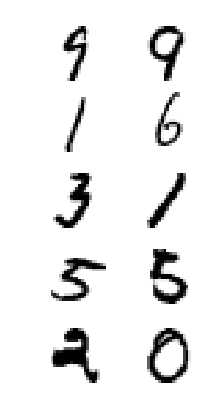

In [85]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [86]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

10.3.train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.

In [0]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [88]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.6910327
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047248
4 Train loss: 0.4060757
5 Train loss: 0.3830816
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.3390794
8 Train loss: 0.3210671
9 Train loss: 0.31792688
10 Train loss: 0.2449429
10 Test accuracy: 0.8881
11 Train loss: 0.29292354
12 Train loss: 0.2322545
13 Train loss: 0.23180933
14 Train loss: 0.19877927
15 Train loss: 0.20065461
15 Test accuracy: 0.9203
16 Train loss: 0.19700496
17 Train loss: 0.18893127
18 Train loss: 0.19965453
19 Train loss: 0.2407165
20 Train loss: 0.18882017
20 Test accuracy: 0.9367
21 Train loss: 0.12419188
22 Train loss: 0.14013407
23 Train loss: 0.120789416
24 Train loss: 0.15721133
25 Train loss: 0.11507861
25 Test accuracy: 0.948
26 Train loss: 0.1389111
27 Train loss: 0.15260805
28 Train loss: 0.123436786
29 Train loss: 0.11543136
30 Train loss: 0.1140284
30 Test accuracy: 0.9507
31 Train loss: 0.11897058
32 Train loss: 0.

**10.4**.create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the tf.stop_gradient() function. Note that we need one Saver to restore the pretrained DNN A, and another Saver to save the final model:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [90]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9724
10 Test accuracy: 0.9743
20 Test accuracy: 0.9738
30 Test accuracy: 0.9726
40 Test accuracy: 0.9734
50 Test accuracy: 0.9728
60 Test accuracy: 0.973
70 Test accuracy: 0.973
80 Test accuracy: 0.9726
90 Test accuracy: 0.9732


In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [92]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9372
30 Test accuracy: 0.9446
40 Test accuracy: 0.9444
50 Test accuracy: 0.9444
60 Test accuracy: 0.9438
70 Test accuracy: 0.9438
80 Test accuracy: 0.9436
90 Test accuracy: 0.9433
100 Test accuracy: 0.9432
110 Test accuracy: 0.9431
120 Test accuracy: 0.9431
130 Test accuracy: 0.9433
140 Test accuracy: 0.9432
